# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_T0 = pd.read_csv('Tweets.csv', sep=',')
print(data_T0.shape)

(14640, 15)


In [3]:
# Filtre de tweets avec un niveau de confiance à 1 sur le sentiment
data_T1 = data_T0[data_T0['airline_sentiment_confidence']==1]
print(data_T1.shape)

data_T1.groupby('airline_sentiment')['airline_sentiment'].count()

(10445, 15)


airline_sentiment
negative    7382
neutral     1548
positive    1515
Name: airline_sentiment, dtype: int64

In [4]:
# Sélection de 1500 tweets positif et 1500 tweets négatifs

data_Tneg = data_T1[data_T1['airline_sentiment']=='negative'].iloc[0:1500]
data_Tpos = data_T1[data_T1['airline_sentiment']=='positive'].iloc[0:1500]
data_T = pd.concat((data_Tneg, data_Tpos), axis=0)
data_T.shape

(3000, 15)

## Nettoyage du texte

In [5]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T['sentence_bow'] = data_T0['text'].apply(lambda x : transform_bow_fct(x))
data_T['sentence_bow_lem'] = data_T0['text'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T0['text'].apply(lambda x : transform_dl_fct(x))
data_T.shape

(3000, 18)

In [6]:
data_T.to_csv("data_tweets2_3000.csv")

# Préparation commune des traitements

In [7]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

#logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [8]:
data_T =  pd.read_csv("data_tweets2_3000.csv")
print(data_T.shape)

(3000, 19)


In [46]:
data_T.head()

,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,...,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentence_bow,sentence_bow_lem,sentence_dl,length_bow,length_dl
0,3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,...,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...,virginamerica really aggressive blast obnoxiou...,virginamerica it 's really aggressive to blast...,11,23
1,4,570300817074462722,negative,1.0,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,...,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing,virginamerica really big bad thing,virginamerica and it 's a really big bad thing...,5,11
2,5,570300767074181121,negative,1.0,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,...,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),virginamerica seriously would pay flight seats...,virginamerica seriously would pay flight seat ...,virginamerica seriously would pay $ 30 a fligh...,12,27
3,17,570276917301137409,negative,1.0,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,...,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada),virginamerica flew nyc sfo last week could n't...,virginamerica flew nyc sfo last week could n't...,virginamerica i flew from nyc to sfo last week...,18,30
4,24,570256553502068736,negative,1.0,Customer Service Issue,0.3557,Virgin America,NaN,ayeevickiee,NaN,...,@VirginAmerica you guys messed up my seating.....,NaN,2015-02-24 08:18:51 -0800,714,Mountain Time (US & Canada),virginamerica guys messed seating reserved sea...,virginamerica guy messed seating reserved seat...,virginamerica you guys messed up my seating .....,15,27


In [9]:
l_cat = list(set(data_T['airline_sentiment']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['airline_sentiment'])) for i in range(len(data_T))]

catégories :  ['positive', 'negative']


In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())


max length bow :  22
max length dl :  42


## Fonctions communes

In [11]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [12]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

## Exécution des modèles

In [13]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)


CountVectorizer : 
-----------------
ARI :  0.5163 time :  80.0

Tf-idf : 
--------
ARI :  0.5192 time :  75.0


## Graphiques

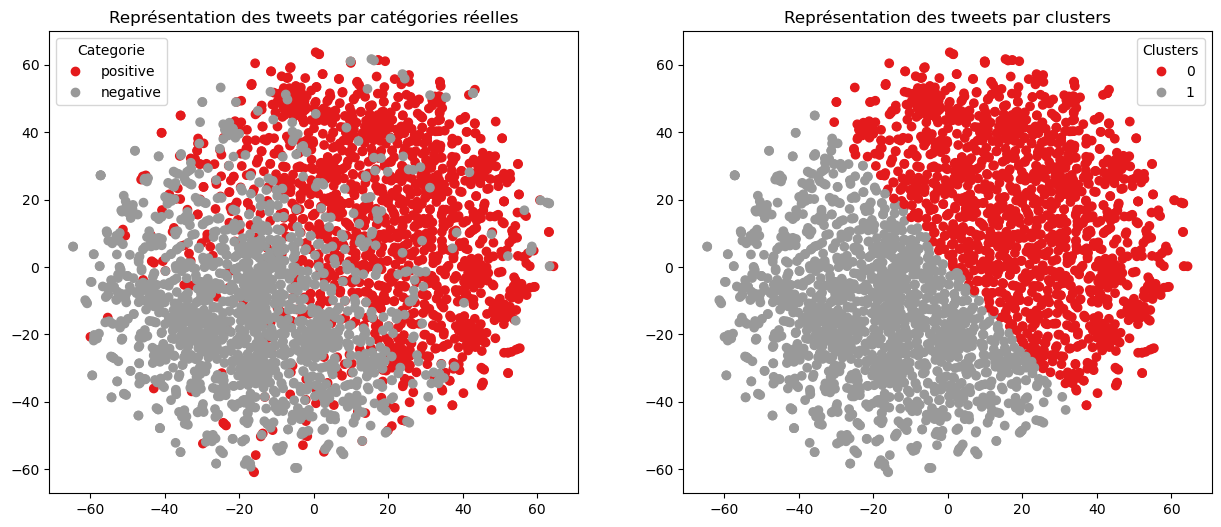

ARI :  0.5192


In [14]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [15]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [16]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [17]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [18]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4809
Word2Vec trained


In [19]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4810


## Création de la matrice d'embedding

In [20]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4810, 300)


## Création du modèle d'embedding

In [21]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

C:\Users\pierr\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 24, 300)             │       1,443,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 300)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,443,000 (5.50 MB)

 Trainable params: 1,443,000 (5.50 MB)

 Non-trainable params: 0 (0.00 B)

## Exécution du modèle

In [22]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(3000, 300)

In [23]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.601 time :  88.0


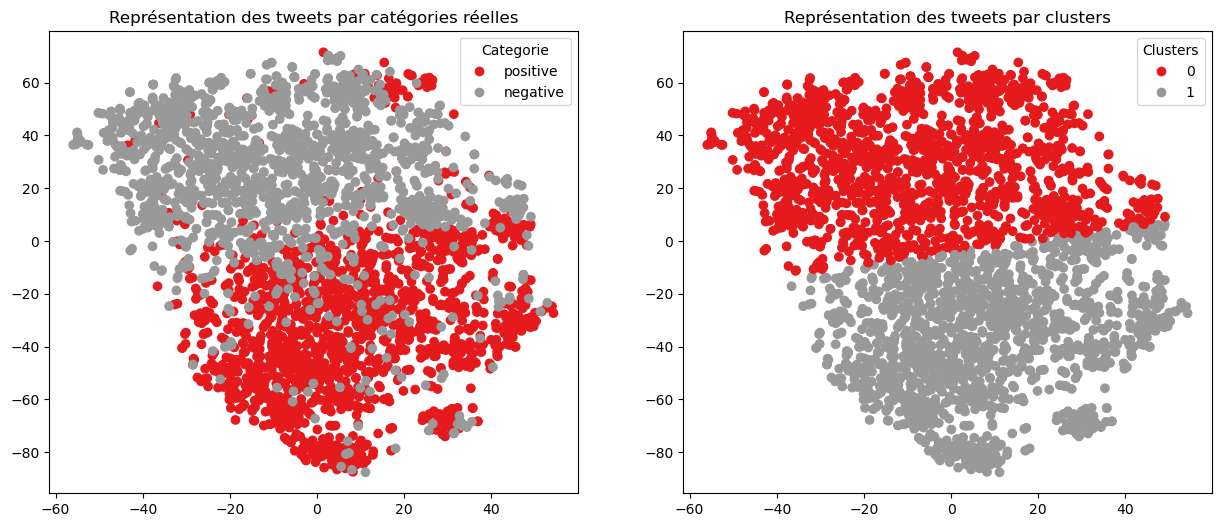

ARI :  0.601


In [24]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [25]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\pierr\anaconda3\Lib\site-packages\transformers\deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [26]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


## Fonctions communes

In [27]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [28]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a6

Loaded 109,482,240 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on

In [29]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\pierr\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapsh

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\vocab.txt
loading file tokenizer.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--bert-base-uncased\snapshots\86b5e0934494bd15c9632b12f734a8a67f723594\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient


1/1 [==============================] - 1s 1s/step
temps traitement :  473.0


In [30]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.5347 time :  81.0


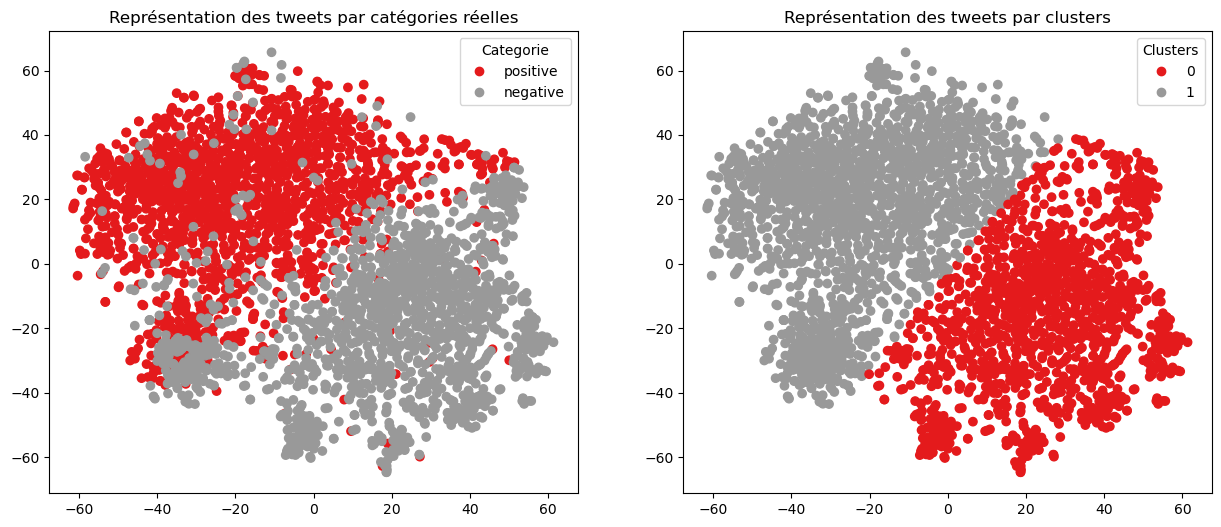

ARI :  0.5347


In [31]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [32]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

C:\Users\pierr\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models-

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

loading weights file tf_model.h5 from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\tf_model.h5
Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was tr

In [33]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

loading file vocab.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\vocab.json
loading file merges.txt from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at C:\Users\pierr\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment\snapshots\daefdd1f6ae931839bce4d0f3db0a1a4265cd50f\config.json
Model config RobertaConfig {
  "_name_or_path": "ca

1/1 [==============================] - 1s 1s/step
temps traitement :  407.0


In [34]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.8836 time :  79.0


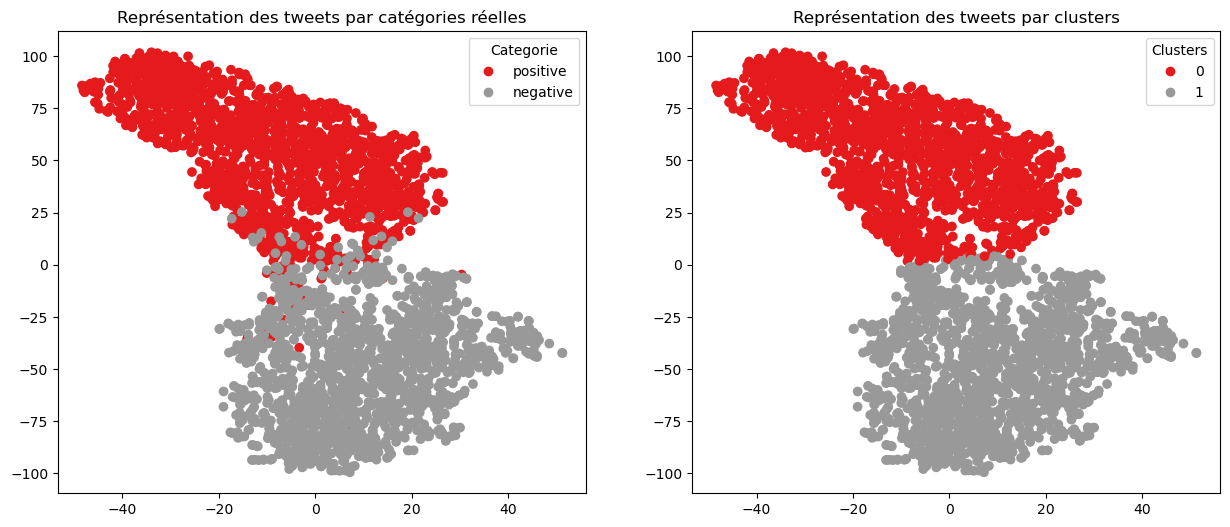

ARI :  0.8836


In [35]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [36]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

ModuleNotFoundError: No module named 'tensorflow_text'

In [ ]:
sentences = data_T['sentence_dl'].to_list()

In [ ]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

In [ ]:
ARI, X_tsne, labels = ARI_fct(features_bert)

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [38]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.16.2
2.16.2
Num GPUs Available:  0
False


In [39]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [42]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [43]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [44]:
features_USE = feature_USE_fct(sentences, batch_size)

In [45]:
ARI, X_tsne, labels = ARI_fct(features_USE)

KeyboardInterrupt: 

In [ ]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)